## CIBER Data Tutorial

This (mini-) tutorial goes through the steps necessary to load in the data/metadata from a given set of detector exposure measurements and perform line fitting to get photocurrent maps. The code associated with this tutorial can be found either in the ciber2 Github repository (https://github.com/zemcov/ciber2_analysis), or in my personal CIBER repository (https://github.com/RichardFeder/ciber). Improvements/extensions of the code are welcome!

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.stats import norm
from ciber2_noise_utils import *
from cross_spectrum_analysis import *
import pickle
import os
from scipy import stats
import re

In [2]:
import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Data initialization

Here we can initialize a number of variables relevant to the set of observations. 
    In this example, we use an exposure from a dark dataset taken in May 2021 from WSMR. 
    This data in this example (exposure 074243) can be downloaded from the CIBER server at
    ciber2@ciber0.rit.edu:/Users/CIBER2/ground_data/36281/WSMR2021May/detector_dark/20210524_detector_dark_data_3channel_vs_indiv/frame_data/



In [9]:
''' Initialize variables relevant to observing run '''

power_supply = 'lab'
exp_number = 74243
# the routines in ciber2_noisedata() use either frames or exposures
frame_or_exp = 'frame'
channel = 2 # channel 1 = L, channel 2 = M, channel 3 = S
# timestr_head is the head of the filenames for most files created with CIBER2
timestr_head = 'RUN05242021'
# the time for each frame of the integration. Note this can vary between lab and flight data
tframe = 1.35168

# We also need to initialize the file paths for our dataset

ext_drive_path = '/Users/luminatech/../../Volumes/Seagate Backup Plus Drive/Toolkit/Mirror/Richard/'
base_path_ext = ext_drive_path+'20210524_detector_dark_data_3channel_vs_indiv'


In the following cell we initialize the detector_readout/ciber2_noisedata classes, which contain some basic data parsing/processing routines. 
    
The detector_readout() class has the numerical routines that carry out the line fit. It initializes ciber2_noisedata() as a subclass, primarily used in the line fit for grabbing frame data.  
    

In [11]:
# create instance of detector_readout() class
dr_obj = detector_readout(exp_number, channel=channel, timestr_head=timestr_head, base_path=base_path_ext, \
                         tframe = tframe)
dr_obj.base_path +='/frame_data/'
dr_obj.nd_obj.indiv_exposure_path = dr_obj.base_path
dr_obj.nd_obj.base_path = dr_obj.base_path

# read_in_run_info() parses the run information from a given datasheet and converts it to a pandas DataFrame object 
run_df = read_in_run_info(base_path_ext+'/detector_dark_tests_05242021_3channel_vs_single.xlsx')
dr_obj.nd_obj.parse_run_df(run_df)

# using the exposure number and the path to frame files for exposures, locates all frame files in the exposure data folder
frame_idxs = dr_obj.nd_obj.get_available_idxs(frame_or_exp='frame', exp_number=exp_number)

('frame_idxs:', array([371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
       384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
       397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
       410, 411, 412, 413]))


## Line fit

Next, we can compute photocurrent maps from an ensemble of frames taken from a given exposure. For each pixel, we assume a constant (sometimes noisy) charge integration for an exposure, from which we perform a line fit to optimally estimate the photocurrent. This assumes the integrated photocurrent is in the linear response regime for the detectors (not necessarily the case for bright signals/long exposures). 

If we were to do line fitting on a per pixel basis, we would take the values of a given pixel over a sequence of frames to make a length $N$ vector. We would then compute the Moore-Penrose inverse to find the length-2 vector $\beta = [b, m]$, where $b$ and $m$ are the DC offset and photocurrent of the integration respectively. The Moore-Penrose inverse is $\beta = (X^T X)^{-1} X^T Y$, where $Y$ is the length $N$ data vector and $X = \left[\begin{array}{cc} 1 & 0 \\ 1 & t_f \\ . &. \\ 1 & N t_f \end{array}\right]$ is a $N \times 2$ matrix.

For this implementation, we take all of the pixels from all of the frames (or a subset of pixels if exceeding memmax) and compute the Moore-Penrose inverse in parallel by expanding $Y$ to a $N \times M$ matrix, where $M$ is the number of pixels on the detector. Then one is left with a $2 \times M$ matrix $\pmb{\beta}$, from which the second column is reshaped into the photocurrent map.

This implementation of exposure line fitting, detector_readout.line_fit(), trades off computational performance with memory usage (the matrix $Y$ stores information from $N_{pix}N_{frames}$ pixels). The default maximum memory is 2048 MB, however this can be reduced with the memmax parameter. This should run for long integrations ($N_{frame} \gtrsim 100$), though it may take longer to run.

Note that the best fit photocurrent maps are scaled to units of electrons per second, using a conversion factor of Volts to electrons (ciber2_noisedata.V_to_e) and the time of each frame.

### Future improvements
Future improvements to the line fitting code include: incorporation of outlier rejection (either at photocurrent map level or at frame level) based on $\chi^2$ of line fit; modeling of weak detector non-linearity, either based on previously derived nonlinearity curves or perhaps directly from a fit to the data; accounting for discontinuities/spurious resets

Splitting up into sub-chunks, memory required for arrays in full (1312 MB) is larger than memmax=512 MB
('Splitting into ', 4, ' chunks..')
('vmin, vmax = ', -0.1384859210497095, 0.17802703386360252)


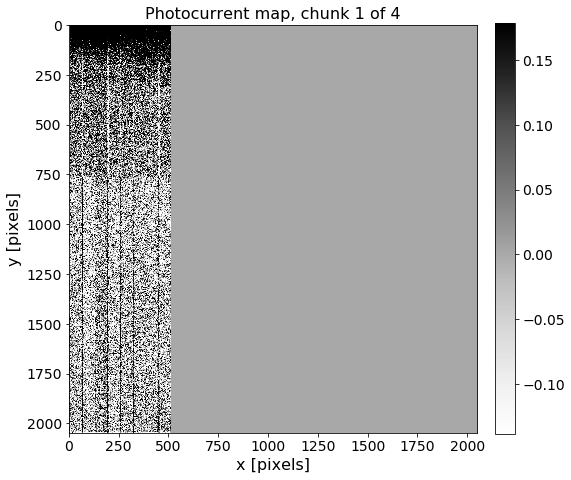

('vmin, vmax = ', -0.20978348517866302, 0.28248976498840833)


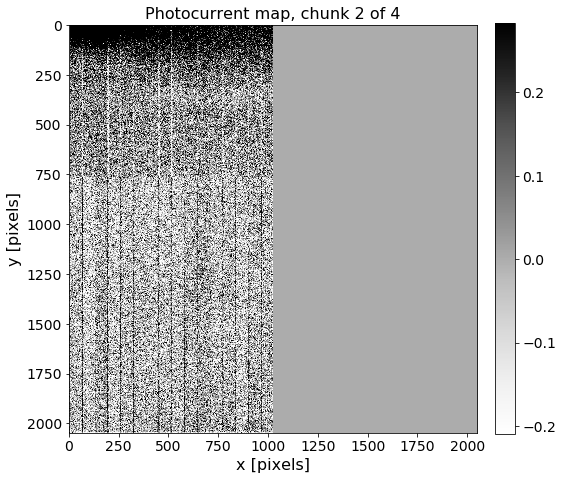

('vmin, vmax = ', -0.2470573072136886, 0.33883695178587236)


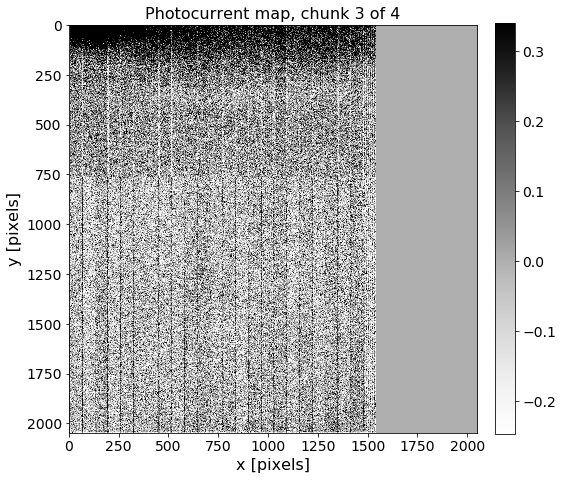

('vmin, vmax = ', -0.2648918563585003, 0.3749072490176751)


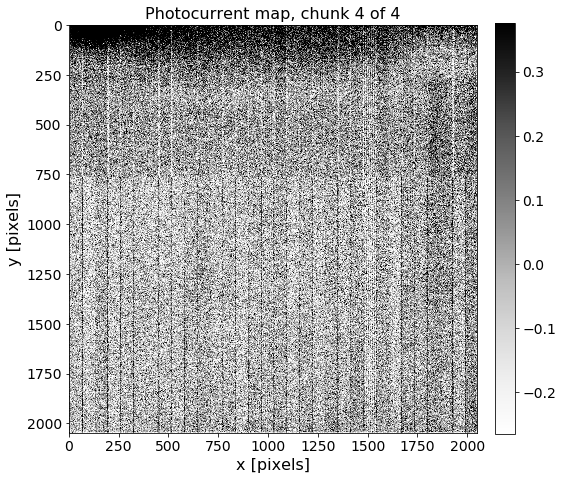

In [12]:
# the parameter postrfr is a boolean telling the function to skip the first nskip frames after a reset frame ("RFR")
postrfr = True
nskip = 2

# run the line fit
bestfitslop = dr_obj.line_fit(frame_idxs, verbose=False, memmax=512, plot=True) # MB

# view the photocurrent map
# view_img(bestfitslop, title='Photocurrent map', figdim=6, maxpercentile=70)

## Reference Pixel Correction

Once the photocurrent map has been made, one can perform reference pixel subtraction if desired.  Reference pixel subtraction is useful when electronic/thermal effects alter the measured photocurrent independent of the incident signal. The 4-pixel wide rim of each CIBER2 detector is composed of reference pixels, which are electrically coupled to the detector but unresponsive to light.

The function detector_readout.subtract_ref_pixels() grabs the reference pixels from each side of the detectors and applies reference pixel subtraction using the bottom and/or top pixels specified in the input 'side_list'. The parameter 'refwide_per_indiv' sets how many columns to average reference pixels over/correct at a time. For a known periodic pattern, one can alternatively use 'refwide_list', which splits up the reference pixels from each 64-column channel, e.g., refwide_list=[20, 44]

### Future improvements
The current code implements a basic version of reference pixel subtraction, however it is currently unclear how they will best be used for CIBER2 data. Future extensions might make use of the left and right side reference pixels, or use some combination of vertical/horizontal facing reference pixels.

('vmin, vmax = ', -0.18375831013212657, 0.20690980457971114)


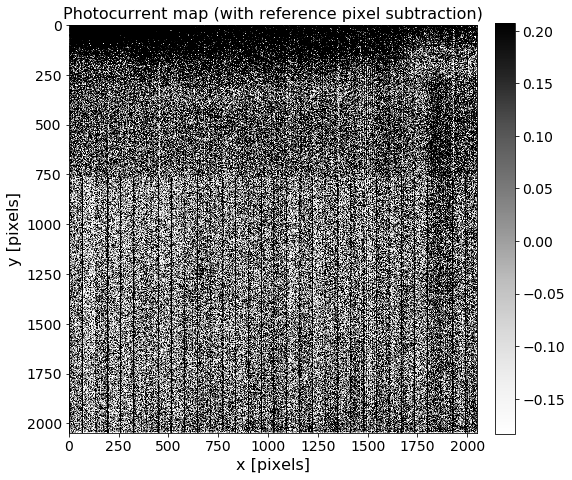

In [14]:
# subtract reference pixels, averaged in 4-column wide increments from the bottom edge of the detector
ref_corrected_arr, _ = dr_obj.subtract_ref_pixels(bestfitslop, refwide_per_indiv=4, side_list=['bottom'])

view_img(ref_corrected_arr, title='Photocurrent map (with reference pixel subtraction)', figdim=8, maxpercentile=70)

I wrote a wrapper function which takes the DataFrame object 'run_df' and computes photocurrent maps for the set of exposures specified in each datasheet we produce associated with some measurement run. run_df is read in with read_in_run_info() and parsed with the function ciber2_noisedata.parse_run_df(). 

Unless 'fits_base_path' is specified in convert_integrations_to_photmaps(), the 'base_path' variable specifies where the photocurrent maps are stored. The function creates a directory "photmaps" within the specified path where maps are saved. The function construct_ciber_photmap_fits() is run, producing a simple fits file with photocurrent map, header values and heeader keys (if specified), and a WCS header (if specified).

In [32]:
timestr_head = 'RUN05242021'
run_info_fname = 'detector_dark_tests_05242021_3channel_vs_single.xlsx'
# convert_integrations_to_photmaps(channel, timestr_head, base_path_ext, run_info_fname=run_info_fname, nskip=2, save_fits=False, plot=True)
